### Notebook for plotting the figures for the Adaptation section

In [45]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from pathlib import Path

In [78]:
# Set figure parameters
country = 'THA'
ADM_level = 'ADM1'
urban = '21'

In [79]:
# Set paths
# Mac Paths
baseline_path = Path(f"/Users/markbernhofen/Projects/flood-wealth/data/results/flood_risk/summary/countries/{country}/{country}_{ADM_level}_metrics_jrc-flood_AALs_baseline_capstock.gpkg")
adapted_path = Path(f"/Users/markbernhofen/Projects/flood-wealth/data/results/flood_risk/summary/countries/{country}/{country}_{ADM_level}_metrics_jrc-flood_AALs_adapted_fp_rp100_duc{urban}_capstock.gpkg")
cost_path = Path(f"/Users/markbernhofen/Projects/flood-wealth/data/results/adaptation/costs/countries/{country}/{country}_adaptation-cost_fp_rp100_duc{urban}_{ADM_level}.gpkg")
# Windows Paths
# baseline_path = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\flood-wealth\data\results\flood_risk\summary\countries\THA\THA_ADM2_metrics_jrc-flood_AALs_baseline_capstock.gpkg"
# adapted_path = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\flood-wealth\data\results\flood_risk\summary\countries\THA\THA_ADM2_metrics_jrc-flood_AALs_adapted_fp_rp100_duc30_capstock.gpkg"
# cost_path = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\flood-wealth\data\results\adaptation\costs\countries\THA\THA_adaptation-cost_fp_rp100_duc30_ADM2.gpkg"

In [80]:
# Load data
baseline = gpd.read_file(baseline_path)
adapted = gpd.read_file(adapted_path)
cost = gpd.read_file(cost_path)
# Adjust cost from millions to actual value
cost['adaptation_cost']*=1e6
cost['adj_adaptation_cost']*=1e6
print(cost['adaptation_cost'].sum())

72178323298.15291


In [81]:
# BCR function
def calculate_bcr(baseline_df, adapted_df, cost_df, time_period=20, discount_rate=0.03):
    # merge all dataframes on shapename
    merged_df = baseline_df[['shapeName', 'total_losses']].merge(
        adapted_df[['shapeName', 'total_losses']],
        on='shapeName',
        suffixes=('_baseline', '_adapted')
    ).merge(
        cost_df[['shapeName', 'adaptation_cost']],
        on='shapeName'
    )
    # Calculate actual benefits
    merged_df['annual_benefits'] = (
        merged_df['total_losses_baseline'] -
        merged_df['total_losses_adapted']
    )
    # Calculate present value of benefits over time period
    if discount_rate ==0:
        pv_factor = time_period
    else:
        pv_factor = (1-(1 + discount_rate)** -time_period) / discount_rate
    merged_df['pv_benefits'] = merged_df['annual_benefits'] * pv_factor
    # Calculate benefit-cost ratio
    merged_df['bcr'] = merged_df['pv_benefits'] / merged_df['adaptation_cost']
    # Handle division by 0 or negative costs
    merged_df['bcr'] = merged_df['bcr'].replace([np.inf, -np.inf], np.nan)
    # Create results dataframe
    results_df = merged_df[[
        'shapeName',
        'annual_benefits',
        'pv_benefits',
        'adaptation_cost',
        'bcr'
    ]]
    # Pull geometry
    results_gdf = baseline_df[['shapeName', 'geometry']].merge(
        results_df,
        on='shapeName',
        how='right'
    )

    return results_gdf

In [82]:
results = calculate_bcr(baseline, adapted, cost, time_period=20, discount_rate=0.03)

In [83]:
results.sort_values('bcr', ascending=False)[:10]

,shapeName,geometry,annual_benefits,pv_benefits,adaptation_cost,bcr
38,Nonthaburi Province,"MULTIPOLYGON (((100.5676 13.95136, 100.54373 1...",295150848.0,4.391099e+09,3.072733e+08,14.290533
58,Pathum Thani Province,"MULTIPOLYGON (((100.91421 13.96126, 100.91415 ...",240122944.0,3.572423e+09,4.119061e+08,8.672907
69,Samut Prakan Province,"MULTIPOLYGON (((100.86078 13.69703, 100.87971 ...",197952128.0,2.945028e+09,4.877081e+08,6.038505
68,Samut Sakhon Province,"MULTIPOLYGON (((100.33298 13.72108, 100.3388 1...",125099200.0,1.861160e+09,3.867414e+08,4.812415
40,Narathiwat Province,"MULTIPOLYGON (((102.07757 6.19003, 102.08054 6...",94915648.0,1.412105e+09,3.431832e+08,4.114727
14,Bangkok,"MULTIPOLYGON (((100.91415 13.94619, 100.90655 ...",246295808.0,3.664260e+09,9.616585e+08,3.810354
60,Nakhon Nayok Province,"MULTIPOLYGON (((101.14022 13.96841, 101.1011 1...",637120.0,9.478737e+06,3.122958e+06,3.035179
27,Nakhon Pathom Province,"MULTIPOLYGON (((100.32785 13.8042, 100.33387 1...",195065536.0,2.902083e+09,1.108244e+09,2.618631
13,Nong Khai Province,"MULTIPOLYGON (((103.10284 18.14075, 103.10474 ...",26352856.0,3.920639e+08,1.897654e+08,2.066045
53,Phra Nakhon Si Ayutthaya Province,"MULTIPOLYGON (((100.59387 14.65584, 100.59109 ...",164402080.0,2.445888e+09,1.907004e+09,1.282581


In [84]:
# Plot
# Simple plotting function
def plot_bcr_map(bcr_gdf, figsize=(12, 8)):
    """
    Plot BCR results on a map.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot BCR with color mapping
    bcr_gdf.plot(
        column='bcr',
        cmap='bwr_r', 
        legend=True,
        ax=ax,
        edgecolor='black',
        linewidth=0.5,
        vmin=0,
        vmax=2,
        missing_kwds={'color': 'lightgray'}  # Color for NaN values
    )
    
    ax.set_title('Benefit-Cost Ratio by Region', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add horizontal line at BCR = 1 in legend if needed
    plt.tight_layout()
    return fig, ax

(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': 'Benefit-Cost Ratio by Region'}, xlabel='Longitude', ylabel='Latitude'>)

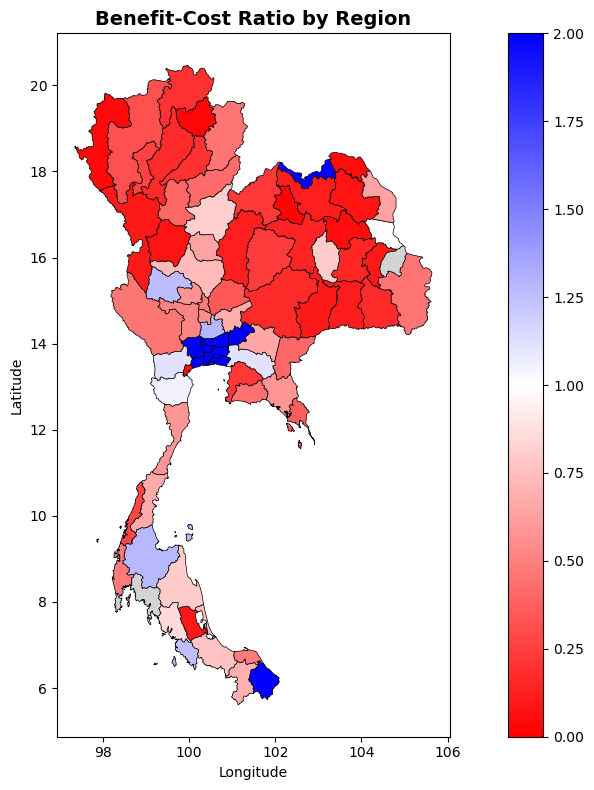

In [85]:
plot_bcr_map(results)